# Contrastive Regression Model

### Load dataset from Kaggle

In [6]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.linear_model import LinearRegression
import kagglehub
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from CustomDataset import AugmentedDataset, NonAugmentedDataset
from Layers.Residual import ResidualBlock, ResidualEncoder

In [2]:
# Download latest version
path = kagglehub.dataset_download("juanda220485/synthetic-dataset-of-speckle-images")
print("Path to dataset files:", path)

Path to dataset files: /Users/petertso/.cache/kagglehub/datasets/juanda220485/synthetic-dataset-of-speckle-images/versions/1


### Transform model as Dataloader

In [7]:
non_aug_dataset = NonAugmentedDataset(path)
aug_dataset     = AugmentedDataset('./dataset_aug')

### View some images of the dataset

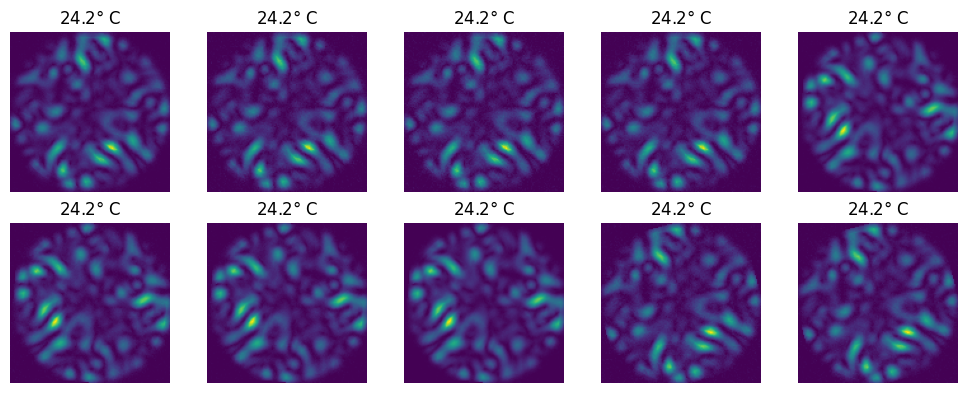

In [8]:
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2, 5, 1 + i)
    image_tensor, temperature = aug_dataset[i]
    image_np = image_tensor.numpy().squeeze()
    img=plt.imshow(image_np)
    plt.title(f"{temperature.item():.1f}$\degree$ C")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Define Model

In [9]:
# Create a DataLoader
batch_size = 16
# Get the total size of the dataset
dataset_size = len(aug_dataset)

# Calculate sizes for training and validation splits
train_size = int(0.9 * dataset_size)
val_size = dataset_size - train_size

# Perform the split
train_dataset, val_dataset = random_split(aug_dataset, [train_size, val_size])

# Create DataLoaders for training and validation
batch_size = 8  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class SupervisedContrastiveRegression(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupervisedContrastiveRegression, self).__init__()
        # Encoder: Feature extractor (e.g., CNN)
        self.encoder = ResidualEncoder(ResidualBlock, [2, 2, 2, 2])  # ResNet-18 architecture

        # Projection head for contrastive learning
        self.projection_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, feature_dim)
        )
        
        # Regression head for temperature prediction
        self.regression_head = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        features = self.encoder(x)  # encoder
        contrastive_latent = self.projection_head(features)  # Projection head
        regression_output = self.regression_head(contrastive_latent)  # Regression head
        return contrastive_latent, regression_output

In [10]:
class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(SupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, targets):
        # Normalize features to unit vectors
        features = F.normalize(features, dim=1)
        
        # Compute pairwise similarity
        similarity_matrix = torch.matmul(features, features.T)
        
        # Scale by temperature
        logits = similarity_matrix / self.temperature
        
        # Targets are used to identify positive pairs
        targets = targets.unsqueeze(1)
        positive_mask = torch.eq(targets, targets.T).float()
        
        # Compute contrastive loss
        logits_exp = torch.exp(logits)
        logits_exp_sum = logits_exp.sum(dim=1, keepdim=True)
        loss = -torch.log(logits_exp / logits_exp_sum) * positive_mask
        loss = loss.sum() / positive_mask.sum()
        
        return loss
    

In [26]:
# Instantiate model, loss, and optimizer
model = SupervisedContrastiveRegression(feature_dim=128)
contrastive_loss_fn = SupervisedContrastiveLoss(temperature=0.1)
regression_loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 32
device = "cpu"

# Function to calculate metrics
def calculate_metrics(predictions, targets):
    # Ensure predictions and targets are flattened to 1D arrays
    predictions = predictions.detach().cpu().numpy().flatten()
    targets = targets.detach().cpu().numpy().flatten()
    
    # Check that they are collections
    if predictions.size == 1 or targets.size == 1:
        raise ValueError("Both predictions and targets must contain multiple samples.")
    
    # Calculate metrics
    mae = np.mean(np.abs(predictions - targets))  # Mean Absolute Error
    mse = np.mean((predictions - targets)**2)    # Mean Squared Error
    r2 = r2_score(targets, predictions)          # R^2 Score
    
    return mae, mse, r2

# Training loop with metrics
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    mae_total, mse_total, r2_total = 0, 0, 0
    
    for images, temperatures in train_loader:  # Assuming DataLoader is defined
        images, temperatures = images.to(device), temperatures.to(device)

        # Forward pass
        contrastive_latent, regression_output = model(images)

        temperatures      = temperatures.view(-1)  # Ensure 1D array
        regression_output = regression_output.squeeze()
        
        # Compute losses
        contrastive_loss = contrastive_loss_fn(contrastive_latent, temperatures)
        regression_loss = regression_loss_fn(regression_output, temperatures)
        
        # Combine losses (weighted sum)
        loss = contrastive_loss + regression_loss
        
        
        # Compute loss
        epoch_loss += loss.item()
        
        # Backpropagation
        optimizer.zero_grad()
        regression_loss.backward()
        optimizer.step()
        
        # Metrics
        mae, mse, r2 = calculate_metrics(regression_output, temperatures)
        mae_total += mae
        mse_total += mse
        r2_total += r2
    
    mae_avg = mae_total / len(train_loader)
    mse_avg = mse_total / len(train_loader)
    r2_avg = r2_total / len(train_loader)
    
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader):.4f}, MAE: {mae_avg:.4f}, MSE: {mse_avg:.4f}, R^2: {r2_avg:.4f}")

Epoch 1, Loss: 910.4279, MAE: 19.8945, MSE: 908.3914, R^2: -0.1707
Epoch 2, Loss: 189.7037, MAE: 11.1089, MSE: 187.6374, R^2: 0.7594
Epoch 3, Loss: 126.2782, MAE: 8.4781, MSE: 124.2113, R^2: 0.8296
Epoch 4, Loss: 22.2952, MAE: 3.5884, MSE: 20.2281, R^2: 0.9769
Epoch 5, Loss: 10.3198, MAE: 2.2740, MSE: 8.2527, R^2: 0.9912
Epoch 6, Loss: 10.9242, MAE: 2.3278, MSE: 8.8571, R^2: 0.9889
Epoch 7, Loss: 8.8409, MAE: 2.0425, MSE: 6.7751, R^2: 0.9920
Epoch 8, Loss: 7.4982, MAE: 1.7165, MSE: 5.4317, R^2: 0.9884
Epoch 9, Loss: 7.1914, MAE: 1.7951, MSE: 5.1250, R^2: 0.9936
Epoch 10, Loss: 9.1783, MAE: 2.0700, MSE: 7.1119, R^2: 0.9922
Epoch 11, Loss: 7.6937, MAE: 1.8050, MSE: 5.6278, R^2: 0.9941
Epoch 12, Loss: 8.7937, MAE: 1.9975, MSE: 6.7279, R^2: 0.9929
Epoch 13, Loss: 5.6109, MAE: 1.5000, MSE: 3.5457, R^2: 0.9958
Epoch 14, Loss: 4.6585, MAE: 1.2412, MSE: 2.5943, R^2: 0.9969
Epoch 15, Loss: 7.4927, MAE: 1.8223, MSE: 5.4279, R^2: 0.9933
Epoch 16, Loss: 15.2661, MAE: 2.8411, MSE: 13.2015, R^2: 0.9

In [27]:
# Set the model to evaluation mode
model.eval()

# Store predictions and true values
predictions = []
true_temperatures = []

# Disable gradient calculation for inference
mae_total = 0
mse_total = 0
r2_total  = 0

with torch.no_grad():
    for images, temperatures in val_loader:
        # Move data to the appropriate device
        images = images.to(device)
        temperatures = temperatures.to(device)
        
        # Forward pass to predict temperatures
        _, predicted_temperatures = model(images)
        
        # Store predictions and true values
        predictions.append(predicted_temperatures.cpu().numpy())
        true_temperatures.append(temperatures.cpu().numpy())

        mae, mse, r2 = calculate_metrics(predicted_temperatures, temperatures)
        mae_total += mae
        mse_total += mse
        r2_total += r2

    mae_avg = mae_total / len(val_loader)
    mse_avg = mse_total / len(val_loader)
    r2_avg = r2_total / len(val_loader)

# Convert lists to numpy arrays for analysis
predictions = np.concatenate(predictions, axis=0)
true_temperatures = np.concatenate(true_temperatures, axis=0)

print(f"Predicted Temperatures: {predictions.flatten()[:5]}")
print(f"True Temperatures: {true_temperatures.flatten()[:5]}")
print(f"MAE: {mae_avg:.4f}, MSE: {mse_avg:.4f}, R^2: {r2_avg:.4f}")

Predicted Temperatures: [ 94.38499   115.0212     82.96552     7.6613364  80.87014  ]
True Temperatures: [ 96.6 119.6  84.2   8.8  81.4]
MAE: 1.8447, MSE: 4.8232, R^2: 0.9962


### Linear Regression

In [34]:
from sklearn.linear_model import LinearRegression

X_train, y_train = [], []
for images, temperatures in train_loader:
    # Flatten images and collect data
    X_train.append(images.view(images.size(0), -1).numpy())
    y_train.append(temperatures.numpy())

# Concatenate all collected batches into a single dataset
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Evaluate on validation set
X_val, y_val = [], []
for images, temperatures in val_loader:
    # Flatten images and collect data
    X_val.append(images.view(images.size(0), -1).numpy())
    y_val.append(temperatures.numpy())

# Concatenate validation data
X_val = np.concatenate(X_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

# Make predictions
y_pred = lr_model.predict(X_val)

# Evaluate performance
r2 = r2_score(y_val, y_pred)
print(f"Validation R^2 Score: {r2:.4f}")

# Example predictions
print("True temperatures:", y_val[:5])
print("Predicted temperatures:", y_pred[:5])

Validation R^2 Score: 1.0000
True temperatures: [ 96.6 119.6  84.2   8.8  81.4]
Predicted temperatures: [ 96.58638  119.58078   84.21831    8.804947  81.398056]
